<a href="https://colab.research.google.com/github/kimdesok/Statistical-Thinking-in-Python-Part-2/blob/main/Stats_by_Python6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bootstrap confidence intervals
>* Resampled data used - Bootstrap samples and replicates
>* A bootstrap sample is an array of length that was drawn from the original data with replacement.
>* A bootstrap replicate is a single value of a statistic computed from a bootstrap sample


In [14]:
# Import plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

#Importing numpy
import numpy as np

import pandas as pd

#Load a csv file at the Google drive to the colab
file_path = r'/content/drive/MyDrive/datasets/sheffield_weather_station.csv'
rainfall = np.loadtxt(fname=file_path, skiprows=9, usecols=5) #delimiter default is whitespace
print(rainfall)

file_path = r'/content/drive/MyDrive/datasets/mlb_nohitters.csv'
nohitter_game_no = np.loadtxt(fname=file_path, skiprows=1, usecols=range(1,2), delimiter=',')
nohitter_times = []

file_path = r'/content/drive/MyDrive/datasets/female_literacy_fertility.csv'

df = pd.read_csv(file_path)

literacy = df['female literacy']

illiteracy = 100.0 - literacy

fertility = df['fertility']

for i in range(len(nohitter_game_no)-1):
  nohitter_times.append(nohitter_game_no[i+1] - nohitter_game_no[i])

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

[122.1  69.8  29.6 ...  65.8  58.2 130.4]


#Visualizing bootstrap samples
>* generating a series of bootstrap samples from the original data
>* generate the corresponding series of ECDF from the bootstrap samples (bootstrap replicates)
>* generate the ECDF from the original data
>* compare these two types of ECDFs 

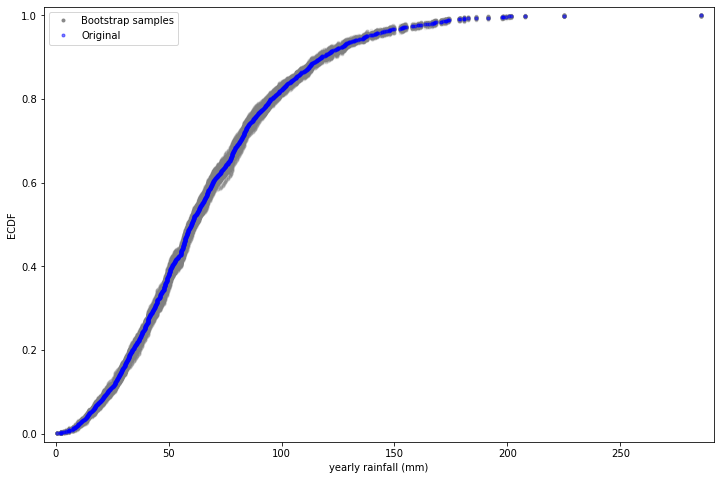

In [3]:
plt.figure(figsize=(12,8))

#calculate the bootstrap replicates
for i in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(rainfall, size=int(len(rainfall)))
    #print(bs_sample.mean(), bs_sample.std())

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = plt.plot(x, y, marker='.', linestyle='none', color='gray', alpha=0.1)

__ = plt.plot(x, y, marker='.', linestyle='none', color='gray', alpha=0.9, label='Bootstrap samples')

# Compute and plot ECDF from original data
x, y = ecdf(rainfall)
_ = plt.plot(x, y, marker='.', linestyle='none', color='blue', alpha=0.5, label='Original')
#print(rainfall.mean(), rainfall.std())

# Make margins and label axes

plt.margins(0.02)
_ = plt.xlabel('yearly rainfall (mm)')
_ = plt.ylabel('ECDF')

# Show the plot
plt.legend(loc='upper left')
plt.show()

In [4]:
#!mv /content/mlb_nohitters.csv /content/drive/MyDrive/datasets

#Goodness of fit between CDF and ECDF
>* Overlaying the theoretical CDF with empirical ECDF and visual assessment

In [5]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [6]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

0.9488593574676786
0.9514822151678577


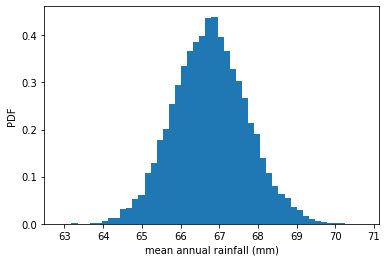

In [7]:
# Take 10,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(rainfall,np.mean,10000)

# Compute and print SEM
sem = np.std(rainfall) / np.sqrt(len(rainfall))
print(sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print(bs_std)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, density=True)
_ = plt.xlabel('mean annual rainfall (mm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

#Confidence intervals
>* A confidence interval provides the upper and lower value on the range of parameter values upon repeating our measurements. 
>* It can be calculated analytically or by bootstraping that provides the precentiles of its replicates.

In [8]:
#95% confidence interval of bootstrap reolicates from the above example
np.percentile(bs_replicates, [2.5, 97.5])*12

array([779.03194757, 824.25769663])

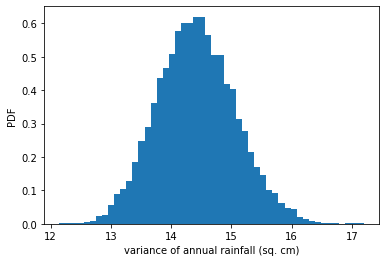

In [9]:
# Generate 10,000 bootstrap replicates of the variance: bs_replicates
bs_replicates = draw_bs_reps(rainfall, np.var, size=9000)

# Put the variance in units of square centimeters
bs_replicates = bs_replicates/100.0

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, density=True)
_ = plt.xlabel('variance of annual rainfall (sq. cm)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

95% confidence interval = [627.72636519 819.40716724] games


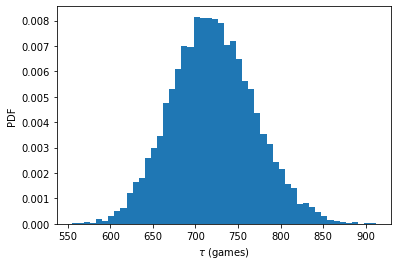

In [10]:
# Draw bootstrap replicates of the mean no-hitter time (equal to tau): bs_replicates
bs_replicates = draw_bs_reps(nohitter_times, np.mean, size=9000)

# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'games')

# Plot the histogram of the replicates
_ = plt.hist(bs_replicates, bins=50, density=True)
_ = plt.xlabel(r'$\tau$ (games)')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

#Pairs bootstrap
>* Pairs bootstrap involves resampling pairs of data. 
>* Each collection of pairs fit with a line (np.polyfit()).
>* Get bootstrap replicates of the parameter values

In [13]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0, len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, deg=1)

    return bs_slope_reps, bs_intercept_reps

[0.04404744 0.05548669]


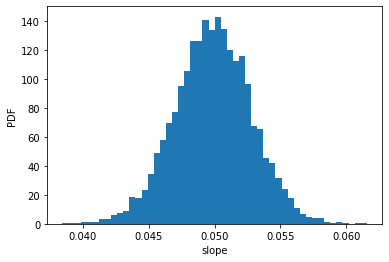

In [18]:
# Generate replicates of slope and intercept using pairs bootstrap
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(illiteracy, fertility, size = 10000 )

# Compute and print 95% CI for slope
print(np.percentile(bs_slope_reps, [2.5, 97.5]))

# Plot the histogram
_ = plt.hist(bs_slope_reps, bins=50, density=True)
_ = plt.xlabel('slope')
_ = plt.ylabel('PDF')
plt.show()

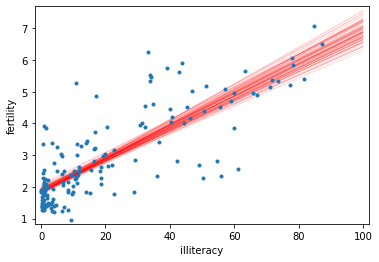

In [19]:
# Generate array of x-values for bootstrap lines: x
x = np.array([0, 100])

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(x, 
                 bs_slope_reps[i]*x + bs_intercept_reps[i],
                 linewidth=0.5, alpha=0.2, color='red')

# Plot the data
_ = plt.plot(illiteracy, fertility, marker='.', linestyle='none')

# Label axes, set the margins, and show the plot
_ = plt.xlabel('illiteracy')
_ = plt.ylabel('fertility')
plt.margins(0.02)
plt.show()